In [297]:
"""
A prototype implementation of Use Case 9
"""

import xarray as xr
import os
import numpy as np
from ipywidgets import interact
from mpl_toolkits import basemap
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

In [298]:
# This is just a prototype, hence the hard coded paths
CLOUD_ECV_PATH = '/home/ccitbx/cci_data/cloud/2008/'
AEROSOL_ECV_PATH = '/home/ccitbx/cci_data/aerosol/2008_monthly/'

In [309]:
# Define the functions that the prototype is going to use

def read_data(path):
    """
    Read in multiple netCDF files and combine them in an xarray dataset.

    :rtype: xr.Dataset
    :param path: Path to the folder
    :return: The resulting dataset
    """
    path = path + os.sep + '*.nc'
    print(path)
    dataset = xr.open_mfdataset(path, concat_dim='time')
    return dataset

class Plotter:
    def __init__(self, datasets, extents=None):
        """
        A helper class for interactive plotting.
        This is because interact() can't pass keyword arguments
        that don't define a widget to the desired function.
        
        datasets: a dictionary of datsets, keys have to correspond to names 
        in 'plot_datasets'
        extent: a list [lat,lat,lon,lon] that defines the bounding box to show
        in the plot. If not provided, a global plot is made
        """
        self.datasets = datasets
        self.extents = extents
        
    def plot_datasets(self, names, t):
        """
        A function for interactive plotting.
        """
        array_slice = self.datasets[names].isel(time=t)
        fig=plt.figure(figsize=(16, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        if self.extents:
            ax.set_extent(self.extents, ccrs.PlateCarree())
        else:
            ax.set_global()
        ax.coastlines()
        array_slice.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
    
    
def resample_slice(slice, grid_lon, grid_lat, order=1):
    """
    Resample a single time slice of a larger xr.DataArray

    :param slice: xr.DataArray single slice
    :param grid_lon: meshgrid of longitudes for the new grid
    :param grid_lat: meshgrid of latitudes for the new grid
    :param order: Interpolation method 0 - nearest neighbour, 1 - bilinear (default), 3 - cubic spline
    :return: xr.DataArray, resampled slice
    """
    result = basemap.interp(slice.values, slice['lon'].data, slice['lat'].data, grid_lon, grid_lat)
    return xr.DataArray(result)


def resample_array(array, lon, lat, order=1):
    """
    Resample the given xr.DataArray to a new grid defined by grid_lat and grid_lon

    :param array: xr.DataArray with lat,lon and time coordinates
    :param lat: 'lat' xr.DataArray attribute for the new grid
    :param lon: 'lon' xr.DataArray attribute for the new grid
    :param order: 0 for nearest-neighbor interpolation, 1 for bilinear interpolation,
    3 for cubic spline (default 1). order=3 requires scipy.ndimage.
    :return: None, changes 'array' in place.
    """
    # Don't do anything if this DataArray has different dims than expected
    if 'time' not in array.dims or 'lat' not in array.dims or 'lon' not in array.dims:
        return array

    #if array.dims != (('time','lat','lon')):
    #    return array

    print(array.name)
    print(array.dims)

    grid_lon, grid_lat = np.meshgrid(lon.data, lat.data)
    kwargs = {'grid_lon':grid_lon, 'grid_lat':grid_lat}
    temp_array = array.groupby('time').apply(resample_slice, **kwargs)
    chunks = list(temp_array.shape[1:])
    chunks.insert(0,1)
    return xr.DataArray(temp_array.values,
                        name = array.name,
                        dims = array.dims,
                        coords = {'time':array.time, 'lat':lat, 'lon':lon},
                        attrs = array.attrs).chunk(chunks=chunks)

In [310]:
# Read in data
ds_clouds = read_data(CLOUD_ECV_PATH)
ds_aerosol = read_data(AEROSOL_ECV_PATH)

/home/ccitbx/cci_data/cloud/2008//*.nc
/home/ccitbx/cci_data/aerosol/2008_monthly//*.nc


In [311]:
# Rename the aerosol dataset's coordinates to correspond with clouds
ds_aerosol.rename({'latitude':'lat', 'longitude':'lon'},inplace=True)

# Select the variables of interest
cc_total = ds_clouds.cc_total
aerosol = ds_aerosol.AOD550_mean

In [312]:
# Regrid the cc_total to the grid used for aerosol
cc_total_resampled = resample_array(cc_total, aerosol['lon'], aerosol['lat'], order=1)

cc_total
('time', 'lat', 'lon')


In [313]:
# Define plotting parameters
names = ['clouds', 'aerosol']
ds = {'clouds':cc_total_resampled, 'aerosol':aerosol}

<function ipywidgets.widgets.interaction.interact.<locals>.<lambda>>

/home/ccitbx/miniconda3/envs/ect_env/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


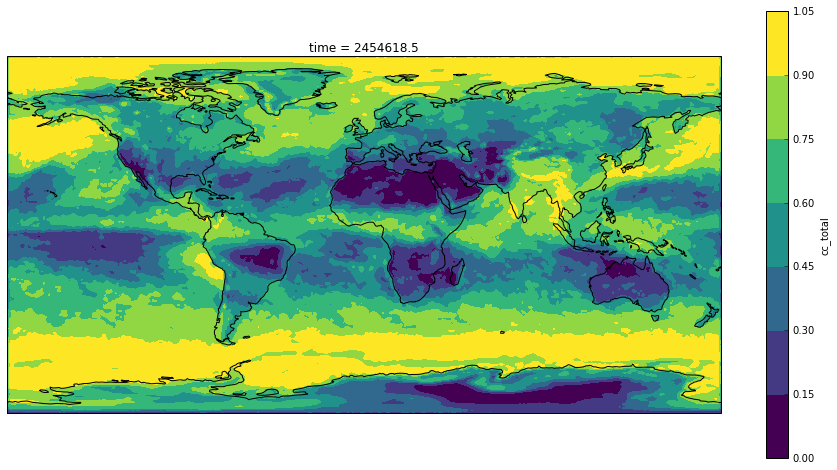

In [314]:
disp = Plotter(ds)
interact(disp.plot_datasets, names = names, t=(0,11,1))

In [315]:
# Select a spatial subset (Africa)
lat_slice = slice(-20., 60.)
lon_slice = slice(-40., 40.)
cc_total_sub = cc_total_resampled.sel(lat=lat_slice,lon=lon_slice)
aerosol_sub = aerosol.sel(lat=lat_slice, lon=lon_slice)


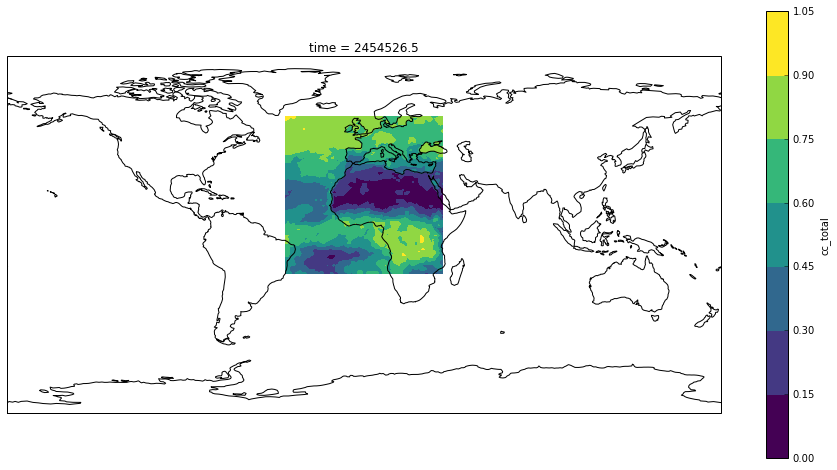

In [316]:
# Plot the subset
ds = {'clouds':cc_total_sub, 'aerosol':aerosol_sub}

disp = Plotter(ds)
interact(disp.plot_datasets, names = names, t=(0,11,1))

In [307]:
print(cc_total_sub)

<xarray.DataArray 'cc_total' (time: 12, lat: 80, lon: 80)>
dask.array<getitem..., shape=(12, 80, 80), dtype=float64, chunksize=(1, 80, 80)>
Coordinates:
  * lon      (lon) float32 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 ...
  * time     (time) float32 2.45447e+06 2.4545e+06 2.45453e+06 2.45456e+06 ...
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 ...
Attributes:
    long_name: cloud fraction
    standard_name: cloud_area_fraction
    units: %
    valid_min: 0.0
    valid_max: 1.0


In [308]:
print(aerosol_sub)

<xarray.DataArray 'AOD550_mean' (time: 12, lat: 80, lon: 80)>
dask.array<getitem..., shape=(12, 80, 80), dtype=float64, chunksize=(1, 80, 80)>
Coordinates:
  * lat      (lat) float32 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 ...
  * lon      (lon) float32 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    long_name: mean aerosol optical density at 550 nm
    standard_name: atmosphere_optical_thickness_due_to_ambient_aerosol
    units: 1
    valid_range: [ 0.  4.]
